# this is the code which runs 'seen diseases' UTH-CCB eval  

The results were calculated for the first draft of the NPJ paper.  These predictions are now stored with the rest of the seen diseases results:

false_positives/data/results/seen_diseases/seen_diseases_y_pred_pri_ref_dataset_test_model_uth_ccb.npy 

And the labels are:
    
false_positives/data/results/seen_diseases/seen_diseases_y_true_pri_ref_dataset_test_model_uth_ccb.npy

Therefore the paths in the outputs below don't match the current on-disk locations


In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.feature_extraction import DictVectorizer
import scipy
from scipy.sparse import csr_matrix

datasets_folder = 'data/datasets'


experiment='pri_ref'
dataset='dev' # dev or test
number_of_classes=4
window_before_diagnosis=8
window_after_diagnosis=0

# these labels match https://hhsrvmlr1.rvc.ac.uk:8888/notebooks/fp/False%20positives%20-%20CNN%20-%20Dataset%20production.ipynb
class_labels={
    0: '1-never diagnosed',
    1: '2-prior to diagnostic window',
    2: '3-after diagnostic window',
    3: '4-during diagnostic window'}

In [2]:
# the x dataset persistance
# we are using sparse matrices here, so need to save/load in a special way

#https://stackoverflow.com/questions/8955448/save-load-scipy-sparse-csr-matrix-in-portable-data-format

import numpy as np

def save_sparse_csr(filename, array):
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

def load_dataset(dataset='train',number_of_classes=4,window_before_diagnosis=8,window_after_diagnosis=0):
    # dont need the x sets
    #x_1=np.load(datasets_folder+'/x_%s_1_exp_%s.npy' % (dataset,experiment))
    #x_2=np.load(datasets_folder+'/x_%s_2_exp_%s.npy' % (dataset,experiment))
    y_ref=np.load(datasets_folder+'/y_%s_exp_8_classes_%s_window_before_diagnosis_%s_window_after_diagnosis_%s.npy' % 
            (dataset,number_of_classes,window_before_diagnosis,window_after_diagnosis))
    y_pri=np.load(datasets_folder+'/y_%s_exp_9_classes_%s_window_before_diagnosis_%s_window_after_diagnosis_%s.npy' % 
            (dataset,number_of_classes,window_before_diagnosis,window_after_diagnosis))
    return np.vstack([y_ref,y_pri])


In [3]:
def auc(y_test,y_pred):
    import sklearn.metrics
    return sklearn.metrics.roc_auc_score(y_test,y_pred)

def roc(y_test,y_pred, title='Receiver Operating Characteristic'):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.xlabel('1-Specificity (False Positive Rate)')
    plt.show()

def specificity(y_true, y_pred):
    import keras.backend as K 

    # from https://github.com/fchollet/keras/blob/master/keras/metrics.py : matthews_correlation

    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)

    return tn / (tn + fp)

def sensitivity(y_true, y_pred):
    import keras.backend as K 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 1e-07)
    return recall

def ppv(y_true, y_pred):
    import keras.backend as K 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + 1e-07)
    return precision

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import label_ranking_average_precision_score, average_precision_score
from itertools import cycle
import matplotlib
import matplotlib.pyplot as plt

#class_labels = dict of ordinal -> label
def evaluate(y_true, y_pred, class_labels):
    # first drop any classes without an example in the true labels, AUC is undefined in this case
    num_classes=y_true.shape[1]
    drop_classes=list([])
    for i in range(0,num_classes):
        # guard no positive examples, skip them as AUC is undefined in this case
        if sum(y_true[:, i]) == 0:
            drop_classes.append(i)
            
    y_true=np.delete(y_true,drop_classes,axis=1)
    y_pred=np.delete(y_pred,drop_classes,axis=1)
    
    print('dropped %s classes because there were no positive examples in labels (ROC undefined in this case)' % len(drop_classes))
    num_classes=y_true.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='Class {0} (AUC = {1:0.2f})'
                 ''.format(class_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1-specificity)')
    plt.ylabel('True Positive Rate (sensitivity)')
    #plt.title('ROC - sentence classification')
    plt.legend(loc="lower right")
    plt.show()
    
    print('label_ranking_average_precision_score:%s' % label_ranking_average_precision_score(y_true,y_pred))
    print('average_precision_score:%s' % average_precision_score(y_true,y_pred))
    
    # now P/R curve
    from sklearn.metrics import precision_recall_curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    #plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()
    return drop_classes

In [4]:
# load persisted training data

x_train=load_sparse_csr('data/datasets/x_train_uth_exp%s.npy.npz' % experiment)
x_test=load_sparse_csr('data/datasets/x_%s_uth_exp%s.npy.npz'  % (dataset,experiment))

# load persisted label data
# need one-hot encoded for evaluation and categorical for training
y_train_4_class_one_hot=load_dataset('train',number_of_classes,window_before_diagnosis,window_after_diagnosis)
y_train_4_class=np.argmax(y_train_4_class_one_hot,axis=1)

y_test_4_class_one_hot=load_dataset(dataset,number_of_classes,window_before_diagnosis,window_after_diagnosis)
y_test_4_class=np.argmax(y_test_4_class_one_hot,axis=1)

In [1]:
# train & evaluate
from sklearn.svm import LinearSVC

svm = LinearSVC(C=0.000001)
svm.fit(x_train,y_train_4_class)



NameError: name 'x_train' is not defined

dropped 0 classes because there were no positive examples in labels (ROC undefined in this case)


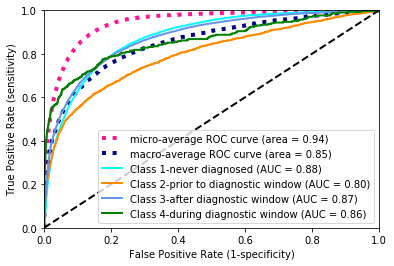

label_ranking_average_precision_score:0.8836355885041138
average_precision_score:0.542331630101342


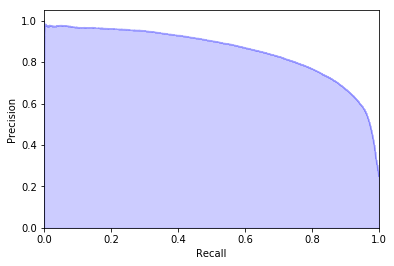

[]

In [6]:

evaluate(y_test_4_class_one_hot, svm.decision_function(x_test),class_labels)

In [7]:
# http://scikit-learn.org/stable/modules/model_persistence.html

from sklearn.externals import joblib

joblib.dump(svm, 'data/models/final_paper_1.0/uth-ccb_%s_%s.pkl' % (experiment,dataset)) 
y_pred = svm.decision_function(x_test)
np.save('data/models/final_paper_1.0/uth-ccb_%s_y_pred.npy' % dataset,y_pred)
np.save('data/models/final_paper_1.0/uth-ccb_%s_y_true.npy' % dataset,y_test_4_class_one_hot)